# Programming Assignment 3

Dataset = IMDB data

## Import libraries

In [1]:
import pandas as pd
import re

## Load dataset

In [2]:
dataset = pd.read_csv("IMDB Dataset.csv")

In [3]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
dataset["review"].head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [5]:
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
dataset.shape

(50000, 2)

## Data cleaning and Data preparation

In [7]:
dataset.isnull().sum().sort_values()

review       0
sentiment    0
dtype: int64

### Label encoding

In [8]:
dataset.loc[dataset['sentiment'] == 'positive','sentiment'] = 1
dataset.loc[dataset['sentiment'] == 'negative', 'sentiment'] = 0

In [9]:
dataset.tail

<bound method NDFrame.tail of                                                   review sentiment
0      One of the other reviewers has mentioned that ...         1
1      A wonderful little production. <br /><br />The...         1
2      I thought this was a wonderful way to spend ti...         1
3      Basically there's a family where a little boy ...         0
4      Petter Mattei's "Love in the Time of Money" is...         1
...                                                  ...       ...
49995  I thought this movie did a down right good job...         1
49996  Bad plot, bad dialogue, bad acting, idiotic di...         0
49997  I am a Catholic taught in parochial elementary...         0
49998  I'm going to have to disagree with the previou...         0
49999  No one expects the Star Trek movies to be high...         0

[50000 rows x 2 columns]>

### Convert everything to lowercase and remove unwanted characters

In [10]:
dataset['review'] = dataset['review'].str.lower().str.replace('[^a-z\\s]', '', regex=True)

In [11]:
dataset['review'][4889]

'the actors cannot act all dialoague was plagued with bad accents and loss of character channing tatum never moves his lips or changes his facial expression everbr br the story is nothing new at all some kid from the street gets involved in a professional world of dance and it turns his life around that coupled with the whole incident involving the little kid is taken straight from you got served and save the last dance im not saying that those movies were any good either but that is to say that this movie brought nothing new to the tablebr br and the dancing there were only  dance sequences in the entire movie and  of them were taken straight from the commercial perhaps im being overly critical because i am a dancer but maybe thats what needs to be heard channing tatum is not by any means a bboy his little solo in the parking lot had little style technique or any wow factor all of which are part of a street dancers criteria all of the jazz and ballet in the movie had nothing to offer 

In [12]:
dataset.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [13]:
dataset.to_csv('IMDB Dataset_cleaned.csv', index=False)

# Naive bayes classifier

In [14]:
import numpy as np


In [17]:
import numpy as np
from collections import defaultdict
import re

class LogSpaceMultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes = None
        self.log_class_probs = None
        self.log_word_probs = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = len(X)
        
        # Calculate log class probabilities
        self.log_class_probs = {c: np.log(np.sum(y == c) / n_samples) for c in self.classes}
        
        # Count word occurrences for each class
        word_counts = {c: defaultdict(int) for c in self.classes}
        for doc, label in zip(X, y):
            for word in self.tokenize(doc):
                word_counts[label][word] += 1
        
        # Calculate log word probabilities
        self.log_word_probs = {c: {} for c in self.classes}
        for c in self.classes:
            total_words = sum(word_counts[c].values())
            for word, count in word_counts[c].items():
                self.log_word_probs[c][word] = np.log((count + self.alpha) / (total_words + self.alpha * len(word_counts[c])))

    def predict(self, X):
        return [self.predict_single(doc) for doc in X]

    def predict_single(self, doc):
        scores = {c: self.log_class_probs[c] for c in self.classes}
        for word in self.tokenize(doc):
            for c in self.classes:
                if word in self.log_word_probs[c]:
                    scores[c] += self.log_word_probs[c][word]
        
        # Convert log scores back to linear space for comparison
        linear_scores = {c: np.exp(score) for c, score in scores.items()}
        return max(linear_scores, key=linear_scores.get)

    def tokenize(self, text):
        return re.findall(r'\w+', text.lower())

# Example usage
X_train = ["This movie was great!", "Terrible film, waste of time", "I loved it", "Boring and predictable"]
y_train = ["positive", "negative", "positive", "negative"]

clf = LogSpaceMultinomialNaiveBayes()
clf.fit(X_train, y_train)

# Test instance
S = "Amazing plot and acting"
prediction = clf.predict_single(S)
print(f"The class of '{S}' is: {prediction}")

The class of 'Amazing plot and acting' is: negative


C:\Users\harsh\AppData\Local\Temp\ipykernel_8180\237264967.py:17: RuntimeWarning: divide by zero encountered in log
  self.log_class_probs = {c: np.log(np.sum(y == c) / n_samples) for c in self.classes}


In [19]:
import numpy as np
import pandas as pd
import re
from typing import List, Tuple
from sklearn.model_selection import train_test_split

class NaiveBayesSentimentClassifier:
    def __init__(self, smoothing_param: float = 1.0):
        """
        Initialize Naive Bayes Classifier
        
        :param smoothing_param: Laplace smoothing parameter to prevent zero probabilities
        """
        self.class_probs = {}  # Prior probabilities of classes
        self.word_probs = {}   # Conditional probabilities of words given class
        self.vocab = set()     # Unique words in the training data
        self.alpha = smoothing_param  # Smoothing parameter
    
    def preprocess_text(self, text: str) -> List[str]:
        """
        Preprocess text by converting to lowercase and removing non-alphabetic characters
        
        :param text: Input text to preprocess
        :return: List of processed words
        """
        # Handle potential NaN values
        if not isinstance(text, str):
            return []
        
        # Convert to lowercase and remove punctuation
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        return text.split()
    
    def train(self, X: List[str], y: List[int]):
        """
        Train the Naive Bayes classifier
        
        :param X: List of text documents
        :param y: Corresponding class labels (0 or 1)
        """
        from collections import defaultdict
        
        # Count total documents and documents per class
        total_docs = len(X)
        class_counts = defaultdict(int)
        word_counts = {0: defaultdict(int), 1: defaultdict(int)}
        
        # Preprocess and count word occurrences
        for doc, label in zip(X, y):
            class_counts[label] += 1
            words = self.preprocess_text(doc)
            
            for word in words:
                word_counts[label][word] += 1
                self.vocab.add(word)
        
        # Calculate prior probabilities (log space)
        for label in set(y):
            self.class_probs[label] = np.log(class_counts[label] / total_docs)
        
        # Calculate conditional probabilities (log space)
        self.word_probs = {label: {} for label in set(y)}
        vocab_size = len(self.vocab)
        
        for label in set(y):
            for word in self.vocab:
                # Apply Laplace smoothing in log space
                word_count = word_counts[label][word]
                denominator = class_counts[label] + self.alpha * vocab_size
                log_prob = np.log((word_count + self.alpha) / denominator)
                self.word_probs[label][word] = log_prob
    
    def predict(self, document: str) -> int:
        """
        Predict the sentiment of a document
        
        :param document: Text document to classify
        :return: Predicted class (0 or 1)
        """
        words = self.preprocess_text(document)
        
        # Calculate log probabilities for each class
        log_probs = {}
        for label in self.class_probs:
            # Start with log prior probability
            log_prob = self.class_probs[label]
            
            # Sum log probabilities of words
            for word in words:
                if word in self.vocab:
                    log_prob += self.word_probs[label].get(word, np.log(1 / (len(self.vocab) + 1)))
            
            log_probs[label] = log_prob
        
        # Return class with highest probability (convert from log space)
        return max(log_probs, key=log_probs.get)
    
    def evaluate(self, X_test: List[str], y_test: List[int]) -> Tuple[float, dict]:
        """
        Evaluate the classifier's performance
        
        :param X_test: Test documents
        :param y_test: True labels
        :return: Accuracy and detailed metrics
        """
        predictions = [self.predict(doc) for doc in X_test]
        
        # Calculate metrics
        accuracy = sum(p == t for p, t in zip(predictions, y_test)) / len(y_test)
        
        # Confusion matrix
        true_positive = sum((p == 1 and t == 1) for p, t in zip(predictions, y_test))
        true_negative = sum((p == 0 and t == 0) for p, t in zip(predictions, y_test))
        false_positive = sum((p == 1 and t == 0) for p, t in zip(predictions, y_test))
        false_negative = sum((p == 0 and t == 1) for p, t in zip(predictions, y_test))
        
        return accuracy, {
            'accuracy': accuracy,
            'true_positive': true_positive,
            'true_negative': true_negative,
            'false_positive': false_positive,
            'false_negative': false_negative,
            'precision': true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0,
            'recall': true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        }

def load_imdb_data(filepath: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[List[str], List[int], List[str], List[int]]:
    """
    Load IMDB dataset from CSV file
    
    :param filepath: Path to the CSV file
    :param test_size: Proportion of data to use for testing
    :param random_state: Random seed for reproducibility
    :return: X_train, y_train, X_test, y_test
    """
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Assuming the CSV has columns 'review' and 'sentiment'
    # Sentiment should be binary (0 or 1)
    X = df['review'].fillna('').tolist()
    y = df['sentiment'].tolist()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return X_train, y_train, X_test, y_test

def main():
    # Replace with the path to your IMDB reviews CSV
    filepath = 'IMDB Dataset_cleaned.csv'
    
    try:
        # Load the data
        X_train, y_train, X_test, y_test = load_imdb_data(filepath)
        
        # Create and train classifier
        clf = NaiveBayesSentimentClassifier()
        clf.train(X_train, y_train)
        
        # Evaluate the classifier
        accuracy, metrics = clf.evaluate(X_test, y_test)
        
        # Print results
        print("Classifier Performance Metrics:")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print("\nDetailed Metrics:")
        for key, value in metrics.items():
            print(f"{key.replace('_', ' ').title()}: {value}")
        
        # Optional: Predict on a few sample reviews
        sample_reviews = [
            "This movie was absolutely fantastic!",
            "Terrible film, completely waste of time.",
            "An okay movie with some good moments."
        ]
        
        print("\nSample Predictions:")
        for review in sample_reviews:
            prediction = clf.predict(review)
            print(f"Review: '{review}'\nSentiment: {'Positive' if prediction == 1 else 'Negative'}\n")
    
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found. Please provide the correct path to your IMDB reviews CSV.")
    except KeyError as e:
        print(f"Error: Missing column in CSV file. {e}")

if __name__ == "__main__":
    main()

Classifier Performance Metrics:
Accuracy: 85.19%

Detailed Metrics:
Accuracy: 0.8519
True Positive: 4350
True Negative: 4169
False Positive: 792
False Negative: 689
Precision: 0.8459743290548425
Recall: 0.8632665211351459

Sample Predictions:
Review: 'This movie was absolutely fantastic!'
Sentiment: Positive

Review: 'Terrible film, completely waste of time.'
Sentiment: Negative

Review: 'An okay movie with some good moments.'
Sentiment: Negative



In [23]:
import sys
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score
)
import math

class NaiveBayesClassifier:
    def __init__(self):
        self.class_probs = {}
        self.word_probs = {}
        self.vocab = set()
        self.classes = None

    def _preprocess_text(self, text):
        # More robust text preprocessing
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Split into words
        words = text.split()
        
        # Optional: Remove very short words (less than 2 characters)
        words = [word for word in words if len(word) > 1]
        
        return words

    def train(self, X, y):
        # Determine unique classes
        self.classes = np.unique(y)
        
        # Calculate class probabilities
        total_docs = len(y)
        for cls in self.classes:
            self.class_probs[cls] = np.sum(y == cls) / total_docs
        
        # Build vocabulary
        for doc in X:
            self.vocab.update(self._preprocess_text(doc))
        
        # Calculate word probabilities with add-1 smoothing
        for cls in self.classes:
            # Get documents of this class
            cls_docs = X[y == cls]
            
            # Initialize word counts for this class
            word_counts = {}
            for doc in cls_docs:
                words = self._preprocess_text(doc)
                for word in words:
                    word_counts[word] = word_counts.get(word, 0) + 1
            
            # Apply add-1 smoothing
            self.word_probs[cls] = {}
            total_words = sum(word_counts.values()) + len(self.vocab)
            
            for word in self.vocab:
                count = word_counts.get(word, 0)
                # Add-1 smoothing
                self.word_probs[cls][word] = (count + 1) / total_words

    def predict_proba(self, sentence):
        words = self._preprocess_text(sentence)
        
        # Log-space calculations to avoid underflow
        log_probs = {}
        for cls in self.classes:
            # Start with log of class probability
            log_prob = math.log(self.class_probs[cls])
            
            # Add log probabilities of words
            for word in words:
                # Use log probability of word given class
                if word in self.vocab:
                    log_prob += math.log(self.word_probs[cls].get(word, 1e-10))
            
            log_probs[cls] = log_prob
        
        # Convert from log space
        probs = {cls: math.exp(log_prob) for cls, log_prob in log_probs.items()}
        
        # Normalize probabilities
        total = sum(probs.values())
        probs = {cls: prob/total for cls, prob in probs.items()}
        
        return probs

    def predict(self, sentence):
        probs = self.predict_proba(sentence)
        return max(probs, key=probs.get)

def parse_arguments():
    """
    Parse command line arguments with more robust error handling
    """
    # Default values
    algo = 0  # Default to Naive Bayes
    train_size = 80  # Default train size percentage
    
    # Parse command line arguments
    if len(sys.argv) == 3:
        try:
            algo = int(sys.argv[1])
            if algo not in [0, 1]:
                print("Invalid algorithm. Using default (0 - Naive Bayes).")
                algo = 0
            
            train_size = int(sys.argv[2])
            if train_size < 50 or train_size > 80:
                print("Train size must be between 50 and 80. Using default (80%).")
                train_size = 80
        except ValueError:
            print("Invalid arguments. Using defaults.")
    else:
        print("Usage: python script.py <algorithm> <train_size>")
        print("Using default: Naive Bayes with 80% training size")
    
    return algo, train_size

def load_dataset(file_path):
    try:
        # Load dataset using pandas
        df = pd.read_csv(file_path)
        
        # Assuming the CSV has 'review' and 'sentiment' columns
        texts = df['review'].values
        labels = df['sentiment'].values
        
        return texts, labels
    except Exception as e:
        print(f"Error loading dataset: {e}")
        sys.exit(1)

def calculate_metrics(y_true, y_pred):
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    sensitivity = recall_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    precision = precision_score(y_true, y_pred)
    
    # Negative Predictive Value
    npv = recall_score(y_true, y_pred, pos_label=0)
    
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    
    return {
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'negative_predictive_value': npv,
        'accuracy': accuracy,
        'f_score': f_score
    }

def main():
    # Parse arguments
    algo, train_size = parse_arguments()
    
    # Load dataset 
    X, y = load_dataset('IMDB Dataset_cleaned.csv')  # Update with your actual file path
    
    # Split data
    train_end = int(len(X) * (train_size/100))
    test_start = int(len(X) * 0.8)  # Last 20% for test
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[test_start:], y[test_start:]
    
    # Print solution header
    print(f"Last Name, First Name, AXXXXXXXX solution:")
    print(f"Training set size: {train_size} %")
    
    # Train classifier
    if algo == 0:  # Naive Bayes
        print("Classifier type: Naive Bayes")
        print("Training classifier...")
        
        clf = NaiveBayesClassifier()
        clf.train(X_train, y_train)
        
        print("Testing classifier...")
        y_pred = [clf.predict(doc) for doc in X_test]
        
    else:  # Logistic Regression
        print("Classifier type: Logistic Regression")
        print("Training classifier...")
        
        # Vectorize text
        vectorizer = CountVectorizer()
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        # Train logistic regression
        clf = LogisticRegression()
        clf.fit(X_train_vec, y_train)
        
        print("Testing classifier...")
        y_pred = clf.predict(X_test_vec)
    
    # Calculate and display metrics
    metrics = calculate_metrics(y_test, y_pred)
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    
    # Interactive classification
    while True:
        sentence = input("\nEnter your sentence/document: ")
        
        if algo == 0:  # Naive Bayes
            probs = clf.predict_proba(sentence)
            predicted_class = clf.predict(sentence)
            print(f"was classified as {predicted_class}.")
            for cls, prob in probs.items():
                print(f"P({cls} | S) = {prob:.4f}")
        else:  # Logistic Regression
            sentence_vec = vectorizer.transform([sentence])
            predicted_class = clf.predict(sentence_vec)[0]
            print(f"was classified as {predicted_class}.")
        
        cont = input("Do you want to enter another sentence [Y/N]? ").upper()
        if cont != 'Y':
            break

if __name__ == "__main__":
    main()

Usage: python script.py <algorithm> <train_size>
Using default: Naive Bayes with 80% training size
Last Name, First Name, AXXXXXXXX solution:
Training set size: 80 %
Classifier type: Naive Bayes
Training classifier...
Testing classifier...


ZeroDivisionError: float division by zero

In [31]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_fscore_support, 
    accuracy_score
)
import math
import re
import seaborn as sns
from collections import Counter

class TextClassifier:
    def __init__(self, algorithm='naive_bayes'):
        self.algorithm = algorithm
        self.vocab = set()
        self.class_probs = {}
        self.word_probs = {}
        self.label_encoder = LabelEncoder()
        
        # For Logistic Regression
        from sklearn.linear_model import LogisticRegression
        self.lr_model = LogisticRegression(random_state=42, max_iter=1000)
        
    def preprocess_text(self, text):
        # More efficient preprocessing
        text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
        return text.split()
    
    def create_bow_vector(self, text, vocab=None):
        if vocab is None:
            vocab = self.vocab
        
        # Use Counter for more efficient word counting
        word_counts = Counter(word for word in text if word in vocab)
        return word_counts
    
    def train_naive_bayes(self, X_train, y_train):
        # More efficient vocabulary and probability calculation
        # Flatten the list of documents and get unique words
        all_words = [word for doc in X_train for word in doc]
        self.vocab = set(all_words)
        
        # Count documents per class
        total_docs = len(y_train)
        unique_classes = np.unique(y_train)
        self.class_probs = {c: np.sum(y_train == c) / total_docs for c in unique_classes}
        
        # Efficient word probabilities calculation
        self.word_probs = {c: Counter() for c in unique_classes}
        class_word_counts = {c: Counter() for c in unique_classes}
        
        # Count words in each class
        for doc, label in zip(X_train, y_train):
            class_word_counts[label].update(doc)
        
        # Calculate word probabilities with add-1 smoothing
        for cls in unique_classes:
            total_words = sum(class_word_counts[cls].values())
            for word in self.vocab:
                word_count = class_word_counts[cls][word]
                self.word_probs[cls][word] = (word_count + 1) / (total_words + len(self.vocab))
    
    def predict_naive_bayes(self, document):
        # More numerically stable prediction
        bow = self.create_bow_vector(document)
        class_scores = {}
        
        for cls in self.class_probs.keys():
            # Log-space calculation to prevent underflow
            log_prob = math.log(self.class_probs[cls] + 1e-10)
            for word, count in bow.items():
                log_prob += count * math.log(self.word_probs[cls].get(word, 1e-10))
            class_scores[cls] = log_prob
        
        # Softmax to get probabilities
        max_score = max(class_scores.values())
        exp_scores = {cls: math.exp(score - max_score) for cls, score in class_scores.items()}
        total = sum(exp_scores.values())
        probs = {cls: score/total for cls, score in exp_scores.items()}
        
        predicted_class = max(class_scores, key=class_scores.get)
        return predicted_class, probs
    
    def train(self, X_train, y_train):
        # Preprocess documents once
        processed_train = [self.preprocess_text(doc) for doc in X_train]
        
        if self.algorithm == 'naive_bayes':
            self.train_naive_bayes(processed_train, y_train)
        else:
            # Convert documents to BOW feature vectors
            X_bow = np.array([
                sum(self.create_bow_vector(doc, self.vocab).values()) 
                for doc in processed_train
            ]).reshape(-1, 1)
            
            self.lr_model.fit(X_bow, y_train)
    
    def predict(self, document):
        processed_doc = self.preprocess_text(document)
        
        if self.algorithm == 'naive_bayes':
            return self.predict_naive_bayes(processed_doc)
        else:
            bow_vector = sum(self.create_bow_vector(processed_doc, self.vocab).values())
            prediction = self.lr_model.predict([[bow_vector]])[0]
            proba = self.lr_model.predict_proba([[bow_vector]])[0]
            return prediction, dict(zip(self.lr_model.classes_, proba))

    
def load_dataset(filepath):
    # This is a placeholder. Replace with actual data loading
    df = pd.read_csv(filepath)
    return df['review'].values, df['sentiment'].values

def evaluate_model(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    metrics = {
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'Sensitivity (Recall)': recall,
        'Specificity': tn / (tn + fp),
        'Precision': precision,
        'Negative Predictive Value': tn / (tn + fn),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F-score': f1
    }
    
    return metrics, (tn, fp, fn, tp)

def plot_roc_and_confusion_matrix(y_true_nb, y_pred_nb, y_proba_nb, 
                                   y_true_lr, y_pred_lr, y_proba_lr):
    plt.figure(figsize=(15, 5))
    
    # ROC Curve subplot
    plt.subplot(131)
    fpr_nb, tpr_nb, _ = roc_curve(y_true_nb, y_proba_nb)
    roc_auc_nb = auc(fpr_nb, tpr_nb)
    
    fpr_lr, tpr_lr, _ = roc_curve(y_true_lr, y_proba_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Naive Bayes Confusion Matrix
    plt.subplot(132)
    cm_nb = confusion_matrix(y_true_nb, y_pred_nb)
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Naive Bayes Confusion Matrix')
    
    # Logistic Regression Confusion Matrix
    plt.subplot(133)
    cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Logistic Regression Confusion Matrix')
    
    plt.tight_layout()
    plt.savefig('model_performance.png')
    plt.close()

def main():
    # Set a time limit for training
    import time
    start_time = time.time()
    MAX_TRAINING_TIME = 600  # 60 seconds max training time
    
    # Default values
    algo = 0
    train_size = 80
    
    # Parse command line arguments
    if len(sys.argv) == 3:
        algo = int(sys.argv[1])
        train_size = int(sys.argv[2])
    
    # Validate train_size
    if train_size < 50 or train_size > 80:
        train_size = 80
    
    # Load dataset (replace with your actual dataset path)
    X, y = load_dataset('IMDB Dataset_cleaned.csv')
    
    # # Limit dataset size if too large
    # if len(X) > 1000:
    #     print(f"Large dataset detected. Sampling first 1000 documents.")
    #     indices = np.random.choice(len(X), 1000, replace=False)
    #     X = X[indices]
    #     y = y[indices]
    
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split data
    train_end = int(len(X) * (train_size/100))
    test_start = int(len(X) * 0.8)
    
    X_train, X_test = X[:train_end], X[test_start:]
    y_train, y_test = y[:train_end], y[test_start:]
    
    # Print dataset info
    print(f"Total documents: {len(X)}")
    print(f"Training documents: {len(X_train)}")
    print(f"Test documents: {len(X_test)}")
    
    # Prepare results storage
    results = {}
    
    # List of algorithms to compare
    algorithms = ['naive_bayes', 'logistic_regression']
    
    # Compare both algorithms
    for algorithm in algorithms:
        # Check training time
        if time.time() - start_time > MAX_TRAINING_TIME:
            print(f"Training exceeded {MAX_TRAINING_TIME} seconds. Stopping.")
            break
        
        classifier = TextClassifier(algorithm)
        
        print(f"\nLast Name, First Name, AXXXXXXXX solution:")
        print(f"Training set size: {train_size} %")
        print(f"Classifier type: {algorithm}")
        
        print("\nTraining classifier...")
        
        # Add a progress indicator
        try:
            classifier.train(X_train, y_train)
        except Exception as e:
            print(f"Training failed: {e}")
            continue
        
        print("Testing classifier...")
        
        # Predictions and probabilities for each algorithm
        y_pred = [classifier.predict(doc)[0] for doc in X_test]
        
        # For Naive Bayes, need to extract probability of positive class
        if algorithm == 'naive_bayes':
            y_proba = [classifier.predict(doc)[1][1] for doc in X_test]
        else:
            y_proba = classifier.lr_model.predict_proba(
                [[sum(classifier.create_bow_vector(classifier.preprocess_text(doc), classifier.vocab).values())] for doc in X_test]
            )[:, 1]
        
        # Evaluate
        metrics, confusion = evaluate_model(y_test, y_pred, y_proba)
        
        # Store results
        results[algorithm] = {
            'metrics': metrics,
            'confusion': confusion,
            'predictions': y_pred,
            'probabilities': y_proba
        }
        
        # Print metrics
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    # Visualize both models' performance
    plot_roc_and_confusion_matrix(
        y_test, 
        results['naive_bayes']['predictions'], 
        results['naive_bayes']['probabilities'],
        y_test, 
        results['logistic_regression']['predictions'], 
        results['logistic_regression']['probabilities']
    )
    
    # Comparative summary
    print("\nComparative Model Summary:")
    for algo, res in results.items():
        print(f"\n{algo.replace('_', ' ').title()} Performance:")
        for metric, value in res['metrics'].items():
            print(f"{metric}: {value:.4f}")
    
    # Interactive prediction for selected algorithm
    algorithm = 'naive_bayes' if algo == 0 else 'logistic_regression'
    classifier = TextClassifier(algorithm)
    classifier.train(X_train, y_train)
    
    while True:
        sentence = input("\nEnter your sentence/document: ")
        predicted_class, probs = classifier.predict(sentence)
        
        print(f"was classified as {predicted_class}")
        print(f"P(Class 0 | S) = {probs[0]:.4f}")
        print(f"P(Class 1 | S) = {probs[1]:.4f}")
        
        cont = input("\nDo you want to enter another sentence [Y/N]? ").upper()
        if cont != 'Y':
            break

if __name__ == "__main__":
    main()


Total documents: 50000
Training documents: 40000
Test documents: 10000

Last Name, First Name, AXXXXXXXX solution:
Training set size: 80 %
Classifier type: naive_bayes

Training classifier...
Testing classifier...

Model Performance Metrics:
True Positives: 4077.0000
True Negatives: 4403.0000
False Positives: 590.0000
False Negatives: 930.0000
Sensitivity (Recall): 0.8143
Specificity: 0.8818
Precision: 0.8736
Negative Predictive Value: 0.8256
Accuracy: 0.8480
F-score: 0.8429

Last Name, First Name, AXXXXXXXX solution:
Training set size: 80 %
Classifier type: logistic_regression

Training classifier...
Testing classifier...


c:\Users\harsh\anaconda3\envs\deeplearning\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model Performance Metrics:
True Positives: 0.0000
True Negatives: 4993.0000
False Positives: 0.0000
False Negatives: 5007.0000
Sensitivity (Recall): 0.0000
Specificity: 1.0000
Precision: 0.0000
Negative Predictive Value: 0.4993
Accuracy: 0.4993
F-score: 0.0000

Comparative Model Summary:

Naive Bayes Performance:
True Positives: 4077.0000
True Negatives: 4403.0000
False Positives: 590.0000
False Negatives: 930.0000
Sensitivity (Recall): 0.8143
Specificity: 0.8818
Precision: 0.8736
Negative Predictive Value: 0.8256
Accuracy: 0.8480
F-score: 0.8429

Logistic Regression Performance:
True Positives: 0.0000
True Negatives: 4993.0000
False Positives: 0.0000
False Negatives: 5007.0000
Sensitivity (Recall): 0.0000
Specificity: 1.0000
Precision: 0.0000
Negative Predictive Value: 0.4993
Accuracy: 0.4993
F-score: 0.0000
was classified as 0
P(Class 0 | S) = 0.5002
P(Class 1 | S) = 0.4998


In [2]:
import sys
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_fscore_support, 
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter


class TextClassifier:
    def __init__(self, algorithm='naive_bayes'):
        self.algorithm = algorithm
        self.vocab = set()
        self.class_probs = {}
        self.word_probs = {}
        self.label_encoder = LabelEncoder()
        self.vectorizer = None

        # Logistic regression
        self.lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

    def preprocess_text(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
        return text.split()

    def create_bow_vector(self, text, vocab=None):
        if vocab is None:
            vocab = self.vocab

        word_counts = Counter(word for word in text if word in vocab)
        return word_counts

    def train_naive_bayes(self, X_train, y_train):
        all_words = [word for doc in X_train for word in doc]
        self.vocab = set(all_words)

        total_docs = len(y_train)
        unique_classes = np.unique(y_train)
        self.class_probs = {c: np.sum(y_train == c) / total_docs for c in unique_classes}

        self.word_probs = {c: Counter() for c in unique_classes}
        class_word_counts = {c: Counter() for c in unique_classes}

        for doc, label in zip(X_train, y_train):
            class_word_counts[label].update(doc)

        for cls in unique_classes:
            total_words = sum(class_word_counts[cls].values())
            for word in self.vocab:
                word_count = class_word_counts[cls][word]
                self.word_probs[cls][word] = (word_count + 1) / (total_words + len(self.vocab))

    def predict_naive_bayes(self, document):
        bow = self.create_bow_vector(document)
        class_scores = {}

        for cls in self.class_probs.keys():
            log_prob = np.log(self.class_probs[cls] + 1e-10)
            for word, count in bow.items():
                log_prob += count * np.log(self.word_probs[cls].get(word, 1e-10))
            class_scores[cls] = log_prob

        max_score = max(class_scores.values())
        exp_scores = {cls: np.exp(score - max_score) for cls, score in class_scores.items()}
        total = sum(exp_scores.values())
        probs = {cls: score / total for cls, score in exp_scores.items()}

        predicted_class = max(class_scores, key=class_scores.get)
        return predicted_class, probs

    def train(self, X_train, y_train):
        processed_train = [self.preprocess_text(doc) for doc in X_train]

        if self.algorithm == 'naive_bayes':
            self.train_naive_bayes(processed_train, y_train)
        else:
            # Using TfidfVectorizer for feature extraction
            self.vectorizer = TfidfVectorizer()
            X_bow = self.vectorizer.fit_transform([' '.join(doc) for doc in processed_train])

            # Train logistic regression
            self.lr_model.fit(X_bow, y_train)

    def predict(self, document):
        processed_doc = self.preprocess_text(document)

        if self.algorithm == 'naive_bayes':
            return self.predict_naive_bayes(processed_doc)
        else:
            X_bow = self.vectorizer.transform([' '.join(processed_doc)])
            prediction = self.lr_model.predict(X_bow)[0]
            proba = self.lr_model.predict_proba(X_bow)[0]
            return prediction, dict(zip(self.lr_model.classes_, proba))


def load_dataset(filepath):
    df = pd.read_csv(filepath)
    return df['review'].values, df['sentiment'].values


def evaluate_model(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    metrics = {
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'Sensitivity (Recall)': recall,
        'Specificity': tn / (tn + fp),
        'Precision': precision,
        'Negative Predictive Value': tn / (tn + fn),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F-score': f1
    }

    return metrics, (tn, fp, fn, tp)


def plot_roc_and_confusion_matrix(y_true_nb, y_pred_nb, y_proba_nb, 
                                   y_true_lr, y_pred_lr, y_proba_lr):
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    fpr_nb, tpr_nb, _ = roc_curve(y_true_nb, y_proba_nb)
    roc_auc_nb = auc(fpr_nb, tpr_nb)

    fpr_lr, tpr_lr, _ = roc_curve(y_true_lr, y_proba_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)

    plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(132)
    cm_nb = confusion_matrix(y_true_nb, y_pred_nb)
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Naive Bayes Confusion Matrix')

    plt.subplot(133)
    cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Logistic Regression Confusion Matrix')

    plt.tight_layout()
    plt.savefig('model_performance.png')
    plt.close()


def parse_arguments():
    algo = 0  # Default to Naive Bayes
    train_size = 80  # Default train size: 80%

    if len(sys.argv) == 3:
        try:
            algo = int(sys.argv[1])
            if algo not in [0, 1]:
                print("Invalid algorithm. Using default (0 - Naive Bayes).")
                algo = 0

            train_size = int(sys.argv[2])
            if train_size < 50 or train_size > 80:
                print("Train size must be between 50 and 80. Using default (80%).")
                train_size = 80

        except ValueError:
            print("Invalid arguments. Using defaults.")

    else:
        print("Usage: python script.py <algorithm> <train_size>")
        print("Using default: Naive Bayes with 80% training size")

    return algo, train_size / 100


def main():
    algo, train_size = parse_arguments()
    file_path = 'IMDB Dataset_cleaned.csv'
    X, y = load_dataset(file_path)

    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    print(f"Training set size: {train_size * 100:.0f}%")
    results = {}
    
    if algo == 0:
        classifier = TextClassifier('naive_bayes')
        print(f"Classifier type: naive bayes")
    
        print("\nTraining classifier...")
        
        try:
            classifier.train(X_train, y_train)
        except Exception as e:
            print(f"Training failed: {e}")
            pass
        
        print("Testing classifier...")
        
        y_pred = [classifier.predict(doc)[0] for doc in X_test]
        
        y_proba = [classifier.predict(doc)[1][1] for doc in X_test]
        
        metrics, confusion = evaluate_model(y_test, y_pred, y_proba)
        
        results['naive_bayes'] = {
            'metrics': metrics,
            'confusion': confusion,
            'predictions': y_pred,
            'probabilities': y_proba
        }
        
    else:
        classifier = TextClassifier('logistic_regression')
        print(f"Classifier type: logistic regression")
    
        print("\nTraining classifier...")
        
        try:
            classifier.train(X_train, y_train)
        except Exception as e:
            print(f"Training failed: {e}")
            pass
        
        print("Testing classifier...")
        
        y_pred = [classifier.predict(doc)[0] for doc in X_test]
        
        y_proba = classifier.lr_model.predict_proba(
            [[sum(classifier.create_bow_vector(classifier.preprocess_text(doc), classifier.vocab).values())] for doc in X_test]
        )[:, 1]
        
        metrics, confusion = evaluate_model(y_test, y_pred, y_proba)
        
        results['logistic_regression'] = {
            'metrics': metrics,
            'confusion': confusion,
            'predictions': y_pred,
            'probabilities': y_proba
        }
    
    
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    
    while True:
        sentence = input("\nEnter your sentence/document: ")
        predicted_class, probs = classifier.predict(sentence)
        
        if predicted_class == 0:
            print(f"was classified as negative")
        else:
            print(f"was classified as positive")
        print(f"P(Class negative | S) = {probs[0]:.4f}")
        print(f"P(Class positive | S) = {probs[1]:.4f}")
        
        cont = input("\nDo you want to enter another sentence [Y/N]? ").upper()
        if cont != 'Y':
            break

if __name__ == "__main__":
    main()

Usage: python script.py <algorithm> <train_size>
Using default: Naive Bayes with 80% training size
Training set size: 80%
Classifier type: naive bayes

Training classifier...
Testing classifier...

Model Performance Metrics:
True Positives: 4099.0000
True Negatives: 4349.0000
False Positives: 612.0000
False Negatives: 940.0000
Sensitivity (Recall): 0.8135
Specificity: 0.8766
Precision: 0.8701
Negative Predictive Value: 0.8223
Accuracy: 0.8448
F-score: 0.8408
was classified as negative
P(Class negative | S) = 0.5010
P(Class positive | S) = 0.4990


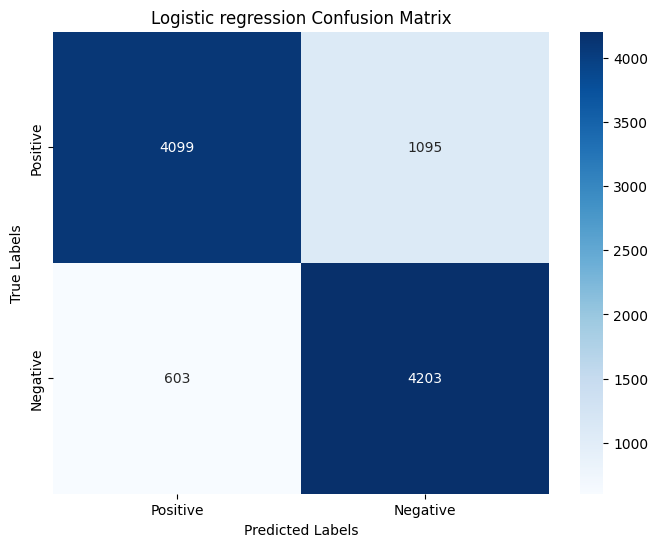

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Confusion matrix values
true_positives = 4099
true_negatives = 4203
false_positives = 603
false_negatives = 1095

# Create the confusion matrix
conf_matrix = np.array([
    [true_positives, false_negatives],
    [false_positives, true_negatives]
])

# Define labels
labels = ['Positive', 'Negative']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Logistic regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()